C:\Users\Sai Vennela Jagadesh\AppData\Local\Temp\ipykernel_18604\3708714105.py:6: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']}, na_values='?', low_memory=False)
C:\Users\Sai Vennela Jagadesh\AppData\Local\Temp\ipykernel_18604\3708714105.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']}, na_values='?', low_memory=False)


First 5 rows of the dataset:
             datetime  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00                4.216                  0.418   234.84   
1 2006-12-16 17:25:00                5.360                  0.436   233.63   
2 2006-12-16 17:26:00                5.374                  0.498   233.29   
3 2006-12-16 17:27:00                5.388                  0.502   233.74   
4 2006-12-16 17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 

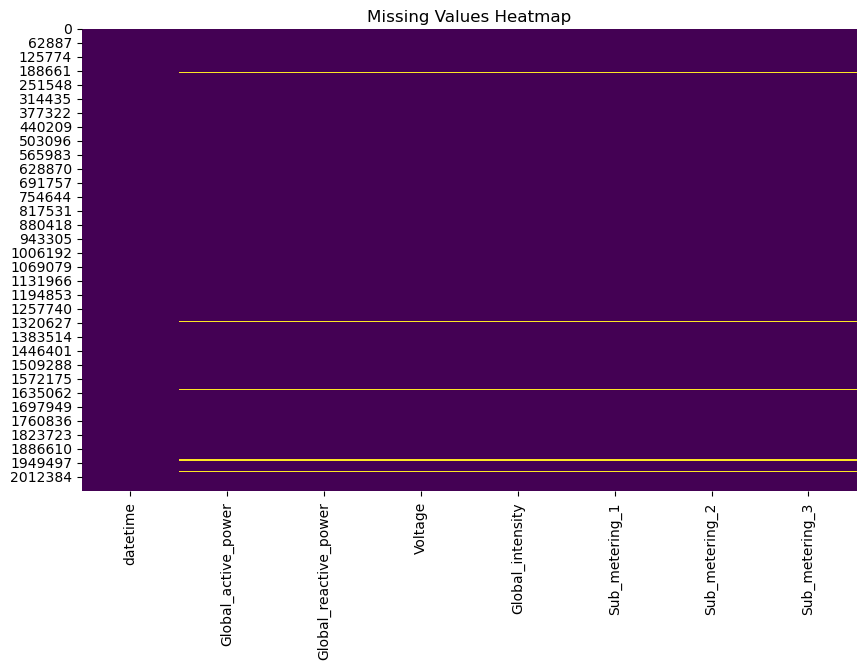

<Figure size 1500x500 with 0 Axes>

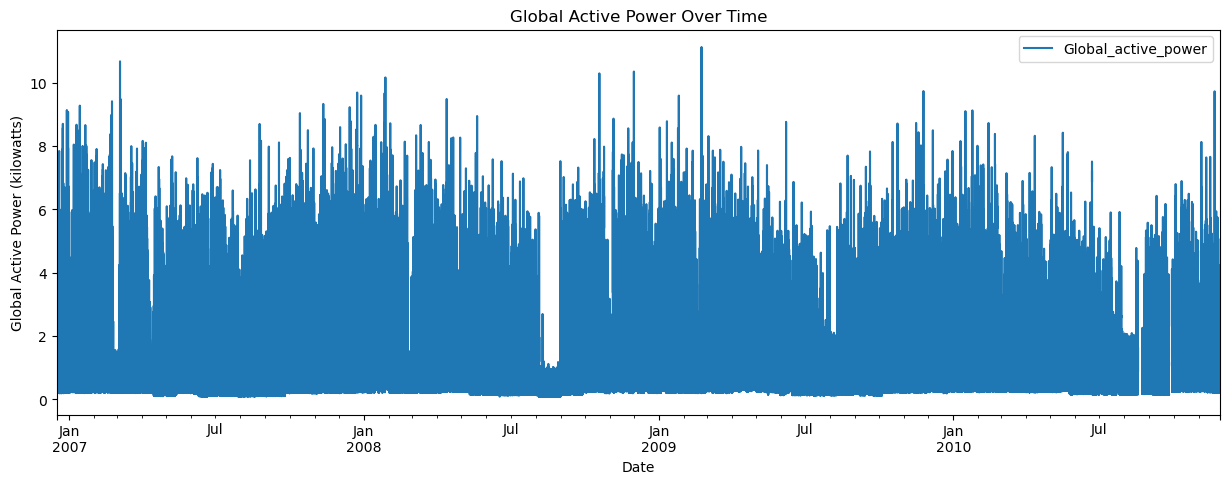

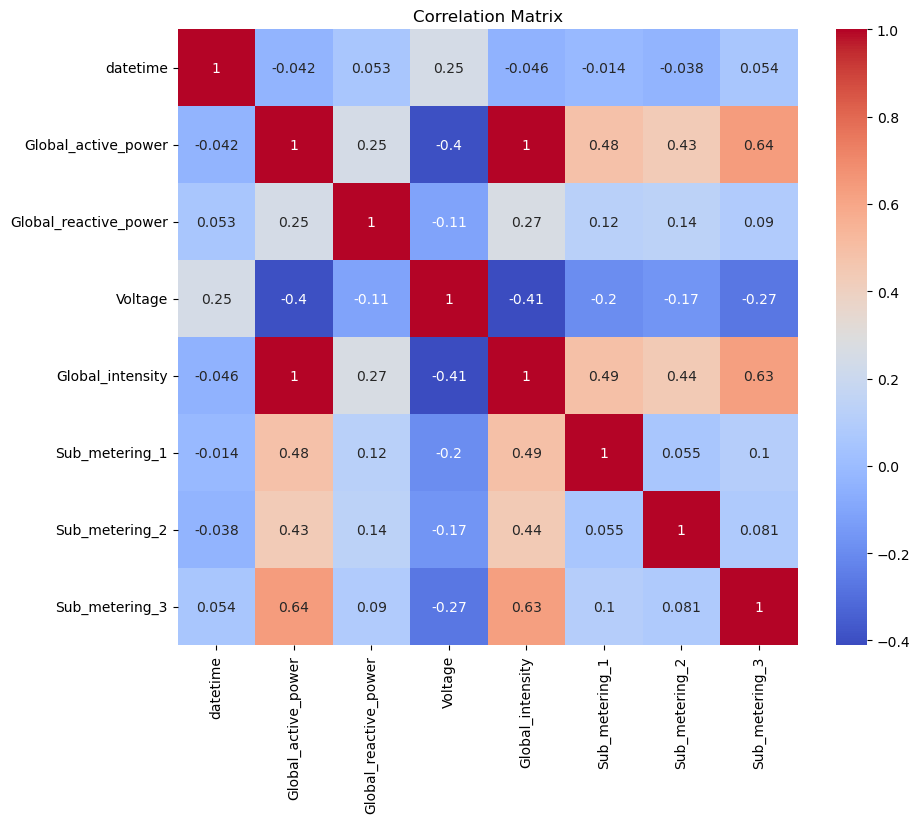

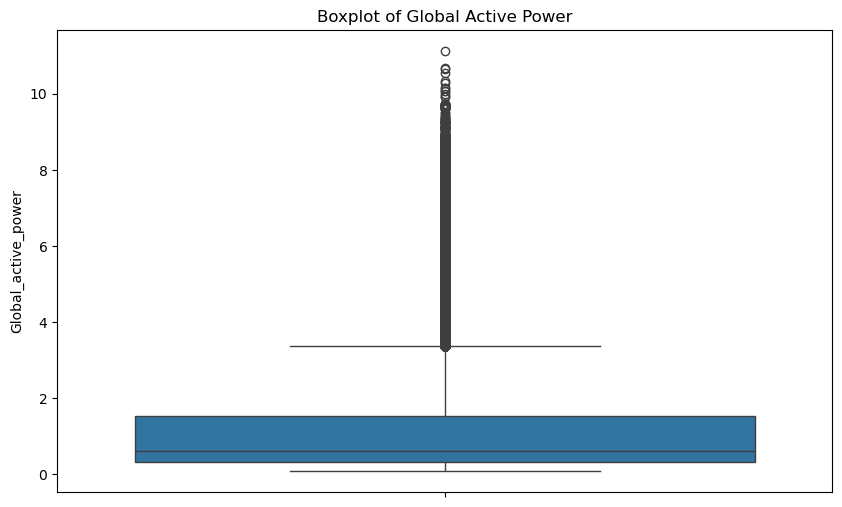

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'C:\\Users\\Sai Vennela Jagadesh\\Documents\\Guvi Capstone Projects\\Household Energy Forecast\\Data\\household_power_consumption.txt'
df = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']}, na_values='?', low_memory=False)

# Basic exploration
print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# EDA: Plot global active power over time
plt.figure(figsize=(15, 5))
df.plot(x='datetime', y='Global_active_power', figsize=(15, 5))
plt.title('Global Active Power Over Time')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Boxplot to detect outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df['Global_active_power'])
plt.title('Boxplot of Global Active Power')
plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming 'df' is the DataFrame from your previous step
# Handle missing values (forward fill for time-series continuity)
df.fillna(method='ffill', inplace=True)  # Alternative: df['Global_active_power'].fillna(df['Global_active_power'].mean())

# Verify missing values are handled
print("Missing Values After Imputation:")
print(df.isnull().sum())

# Parse datetime into features
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.weekday

# Drop original datetime column for modeling
df_model = df.drop(['datetime'], axis=1)

# Normalize/scale numerical features (exclude target 'Global_active_power')
scaler = StandardScaler()
features_to_scale = df_model.drop('Global_active_power', axis=1).columns
df_model[features_to_scale] = scaler.fit_transform(df_model[features_to_scale])

print("\nPreprocessed Data (First 5 Rows):")
print(df_model.head())

C:\Users\Sai Vennela Jagadesh\AppData\Local\Temp\ipykernel_18604\57334131.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Alternative: df['Global_active_power'].fillna(df['Global_active_power'].mean())


Missing Values After Imputation:
datetime                 0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Preprocessed Data (First 5 Rows):
   Global_active_power  Global_reactive_power   Voltage  Global_intensity  \
0                4.216               2.618973 -1.854882          3.116440   
1                5.360               2.778952 -2.228850          4.155571   
2                5.374               3.329993 -2.333932          4.155571   
3                5.388               3.365544 -2.194853          4.155571   
4                3.666               3.596626 -1.595268          2.529104   

   Sub_metering_1  Sub_metering_2  Sub_metering_3      hour       day  \
0       -0.181657       -0.049761        1.257014  0.794432  0.025759   
1       -0.181657       -0.049761        1.138242  0.794432  0.025759   
2       -0.181657    

In [5]:
# Create peak hour feature (6 PM to 10 PM)
df_model['is_peak_hour'] = df_model['hour'].apply(lambda x: 1 if 18 <= x <= 22 else 0)

# Create rolling average (24-hour window, assuming 1-minute data)
df_model['rolling_avg_power'] = df['Global_active_power'].rolling(window=1440).mean()  # 1440 minutes = 24 hours

# Create lagged feature (previous time step's power)
df_model['lagged_power'] = df['Global_active_power'].shift(1)

# Drop rows with NaN values (from rolling/lagged features)
df_model = df_model.dropna()

# Verify new features
print("\nData with Engineered Features (First 5 Rows):")
print(df_model.head())
print("\nNew Features Added:")
print(df_model[['is_peak_hour', 'rolling_avg_power', 'lagged_power']].describe())


Data with Engineered Features (First 5 Rows):
      Global_active_power  Global_reactive_power   Voltage  Global_intensity  \
1439                3.238               0.432585 -2.244303          2.077308   
1440                3.390               0.414809 -2.531733          2.258027   
1441                3.360               0.361483 -2.979876          2.212847   
1442                3.400               0.343707 -2.466829          2.258027   
1443                3.396               0.361483 -2.457558          2.258027   

      Sub_metering_1  Sub_metering_2  Sub_metering_3      hour       day  \
1439       -0.181657       -0.222566        1.138242  0.794432  0.139554   
1440       -0.181657       -0.222566        1.257014  0.794432  0.139554   
1441       -0.181657       -0.222566        1.138242  0.794432  0.139554   
1442       -0.181657       -0.222566        1.257014  0.794432  0.139554   
1443       -0.181657       -0.222566        1.257014  0.794432  0.139554   

         month 